<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
Learning a SDE with NumPyro MCMC
</div>

(Ref : ch11. from Sarkka and Solin "Applied Stochastic Differential Equations")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from tqdm import tqdm
import torchsde

# import pyro
# import pyro.distributions as dist
# import pyro.distributions.constraints as constraints
# from pyro.infer import MCMC, NUTS

import jax.numpy as jnp
import jax
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import summary

from numpyro_models import numpyro_model, numpyro_model_approx
from pyro_utils import display_diag_MCMC_Numpyro, plot_sde_samples, display_posterior_samples

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    # if using a GPU (CUDA) and num_chains > 1
    # torch.multiprocessing.set_start_method('spawn', force=True)
else:
    device = torch.device('cpu')
    
# NB Warning : setting the default_device to CUDA creates a device conflict
# when using a DataLoader, as it uses a CPU-generator for shuffling
torch.set_default_device(device)
print(f"Using {device}")

torch.set_default_dtype(torch.float32)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080 Ti
Total GPU Memory: 11.8 GB


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
Q1 : how much do we loose going from the exact likelihood to a Euler-Maruyama approximation ? - Testing on a O.U.
</div>

Ground truth parameters

In [4]:
lambda_gt = 1.0  # Rate of mean reversion
sigma_gt = 1.0  # Volatility parameter

N_POINTS = 250 # number of points in each y_start = 0.0  # initial condition

t_start = 0.0
t_end = 1.0
ts = torch.linspace(t_start, t_end, N_POINTS).to(device)  # time stamps where we want the solution, between 0 and 1
# print(f"Time stamps shape : {ts.shape}")  # shape (N_POINTS,)

# sanity check on the time scale
dt = (t_end - t_start) / N_POINTS
ldt = dt * lambda_gt

print(f"Delta t = {dt:.3e}")
print(f"Time constant (1/lambda) = {1/ lambda_gt:.3e}")
print(f"lambda . Delta_t = {ldt:.3e}")

Delta t = 4.000e-03
Time constant (1/lambda) = 1.000e+00
lambda . Delta_t = 4.000e-03


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
We generate the data with the exact discretization of an Ornstein Uhnlenbeck process
</div>

\begin{align}
X_{k+1} &= e^{-\lambda (t_{k+1}-t_k)} X_k + \sigma \sqrt{\frac{1-e^{-2 \lambda (t_{k+1}-t_k)}}{2 \lambda}} \mathcal{N}(0,1) \\
X_0 &= x_0
\end{align}

In [19]:
N_PATHS = 1 # number of paths to sample - usually 1, not sure the MCMC is relevant for > 1

# sampling Brownian motions - we will reuse them for the reconstruction
bm = torch.randn((N_POINTS-1, N_PATHS))

y_start = 0.0  # initial condition
ys = torch.full((N_POINTS, N_PATHS), fill_value=y_start)

a = torch.exp(-lambda_gt*torch.tensor(dt))
sigma_sim = sigma_gt * torch.sqrt(1/(2*lambda_gt)*(1-a**2))

for i in tqdm(range(1,N_POINTS)):
    ys[i,:] = a * ys[i-1,:] + sigma_sim * bm[i-1,:]
    
ys = ys.unsqueeze(-1)

100%|██████████| 249/249 [00:00<00:00, 43787.75it/s]


In [21]:
ts.size()

torch.Size([250])

In [22]:
ys.size()

torch.Size([250, 1, 1])

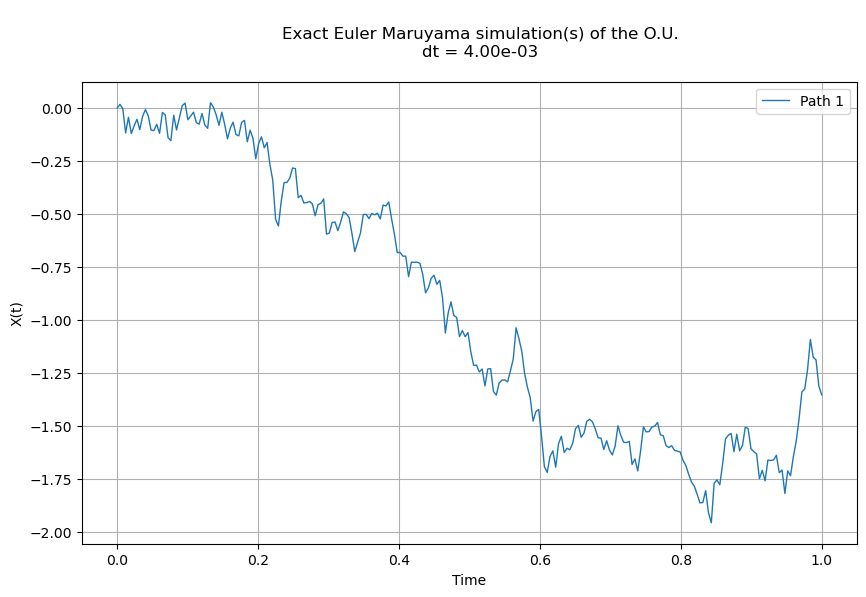

In [20]:
fig, ax = plot_sde_samples(
    ts, ys, 
    title=f"""
    Exact Euler Maruyama simulation(s) of the O.U.
    dt = {dt:.2e}
    """
)

plt.show()

### MCMC Parameters

In [7]:
NUM_WARMUP = 500
NUM_SAMPLES = 100
N_CHAINS = 1

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Q1.1- We use the exact expression of the transition model to compute the likelihood of the model
</div>

Model is `numpyro_model`

The analytical solution of the SDE for the O.U. process is

\begin{align}
X_t &= e^{-\lambda t}X_0 + \sigma \int_{0}^{t}e^{\lambda (s-t)}dB_s \\
X_0 &= x_0
\end{align}

Therefore:
\begin{align}
X_t \vert X_s \sim \mathcal{N}\left( e^{-\lambda (t-s)}X_s \,;\, \frac{\sigma^2}{2 \lambda} (1 - e^{-2 \lambda (t-s)})\right)
\end{align}

In [10]:
nuts_kernel = NUTS(numpyro_model)

MCMC_runner = MCMC(
    nuts_kernel,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=N_CHAINS,
    chain_method="vectorized"
)

MCMC_runner.run(
    jax.random.PRNGKey(0),
    t=jnp.array(ts),
    X=jnp.array(ys)
)

sample: 100%|██████████| 600/600 [00:16<00:00, 36.54it/s, 3 steps of size 7.88e-01. acc. prob=0.89] 


In [11]:
#-------------------------------------------------------------------
# Running checks on MCMC quality
#-------------------------------------------------------------------- 

# check effective sample size, etc. by getting the dictionnary of results
# The structure is: {'<RV_name>': {'n_eff': tensor, 'r_hat': tensor, ...}, ...}
# diags = MCMC_runner.diagnostics()

samples = MCMC_runner.get_samples(group_by_chain=True)
diags = summary(samples)
display_diag_MCMC_Numpyro(diags)

Total number of stochastic parameters analyzed: 2
Overall Average Effective Sample Size (ESS): 50.73
Minimum Effective Sample Size (ESS): 50.13


lambda :
	ground truth : 	1.000e+00
	MAP : 		3.412e-01
sigma :
	ground truth : 	1.000e+00
	MAP : 		1.021e+00


Text(0.5, 0.98, 'Posterior distribution from O.U. model with exact transition')

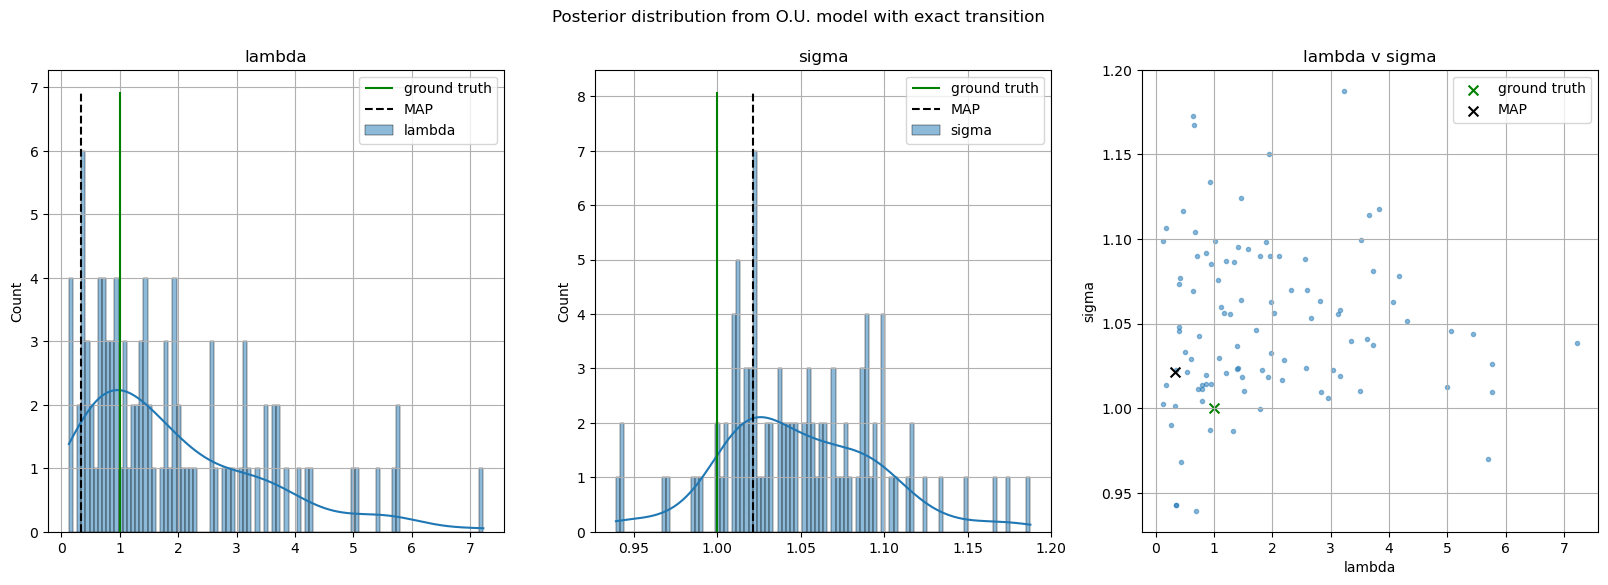

In [12]:
#------------------------------------------------------------------------
# Visual inspection of the posteriors
#------------------------------------------------------------------------

flat_samples = {}
for k,v in samples.items():
    flat_samples[k] = v.reshape(-1,)
    
fig, ax = display_posterior_samples(numpyro_posterior_samples=flat_samples, lambda_gt=lambda_gt, sigma_gt=sigma_gt)
fig.suptitle(f'Posterior distribution from O.U. model with exact transition')

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Q1.2- We use an Euler-Maruyama approximation of the transition model to compute the likelihood in the model
</div>

Model is `numpyro_model_approx`

General formulation : 

\begin{align}
dX_t &= - \lambda X_t dt + \sigma dB_t \\
X_0 &= x_0
\end{align}

So :
\begin{align}
X_t \vert X_s \sim \mathcal{N}\left( (1 - \lambda dt) \, X_s \,;\, \sigma \right)
\end{align}

In [13]:
nuts_kernel = NUTS(numpyro_model_approx)

MCMC_runner = MCMC(
    nuts_kernel,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=N_CHAINS,
    chain_method="vectorized"
)

MCMC_runner.run(
    jax.random.PRNGKey(0),
    t=jnp.array(ts),
    X=jnp.array(ys)
)

sample: 100%|██████████| 600/600 [00:15<00:00, 37.70it/s, 7 steps of size 6.55e-01. acc. prob=0.91] 


In [14]:
#-------------------------------------------------------------------
# Running checks on MCMC quality
#-------------------------------------------------------------------- 

# check effective sample size, etc. by getting the dictionnary of results
# The structure is: {'<RV_name>': {'n_eff': tensor, 'r_hat': tensor, ...}, ...}
# diags = MCMC_runner.diagnostics()

samples = MCMC_runner.get_samples(group_by_chain=True)
diags = summary(samples)
display_diag_MCMC_Numpyro(diags)

Total number of stochastic parameters analyzed: 2
Overall Average Effective Sample Size (ESS): 39.80
Minimum Effective Sample Size (ESS): 39.76


lambda :
	ground truth : 	1.000e+00
	MAP : 		1.355e-01
sigma :
	ground truth : 	1.000e+00
	MAP : 		1.011e+00


Text(0.5, 0.98, 'Posterior distribution from O.U. model with E.M. transition')

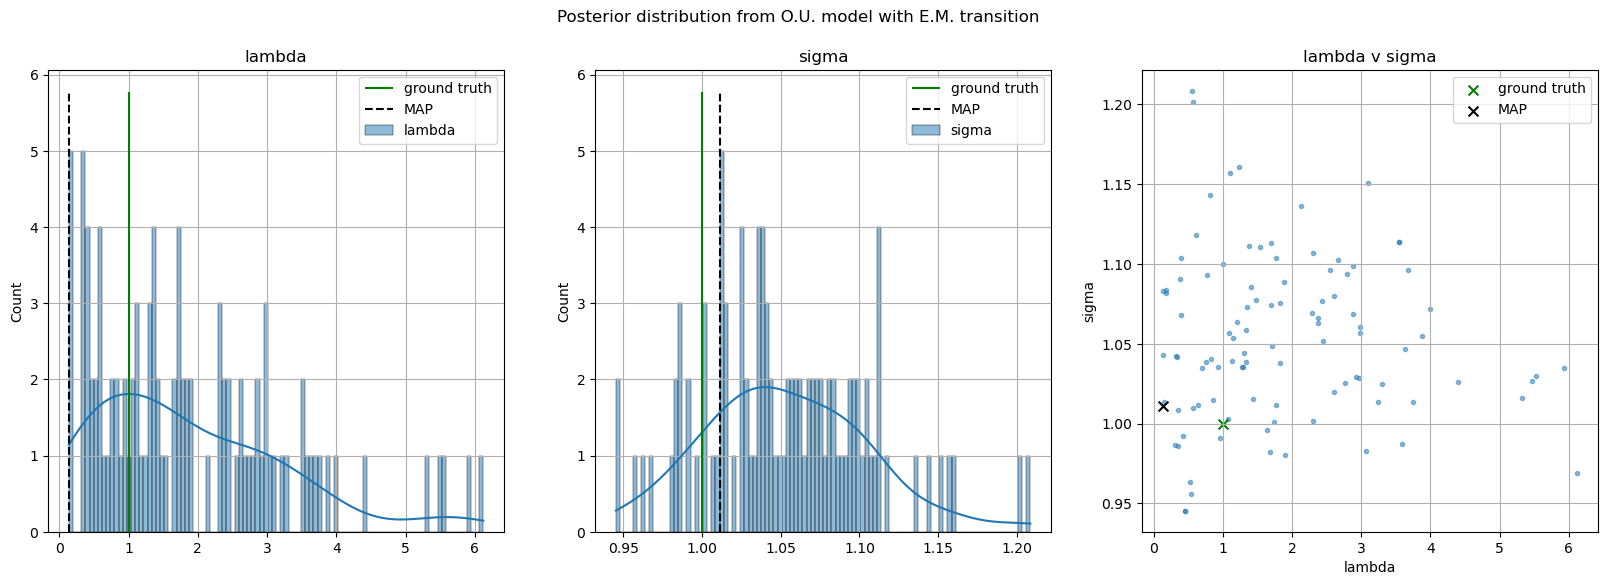

In [15]:
#------------------------------------------------------------------------
# Visual inspection of the posteriors
#------------------------------------------------------------------------

flat_samples = {}
for k,v in samples.items():
    flat_samples[k] = v.reshape(-1,)
    
fig, ax = display_posterior_samples(numpyro_posterior_samples=flat_samples, lambda_gt=lambda_gt, sigma_gt=sigma_gt)
fig.suptitle(f'Posterior distribution from O.U. model with E.M. transition')

### CONCLUSIONS

- the estimations of $\sigma$ by the two transition models are consistent accross different sampling intervals `dt`
- the estimations of $\lambda$ are equally randomly bad between the two models when $\lambda \times dt$ is small, which is a known behavior, as the O.U. process then resembles a Brownian motion.

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
Q2 : Learning a SDE drift and diffusion with Bayesian Neural Nets
</div>

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Data generation with torchsde
</div>

In [34]:
class DataGenerationSDE(nn.Module):
    
    lambda_ = 1.0
    sigma_ = 1.0
    
    def __init__(self):
        
        # noise type can take 4 values : "diagonal", "general", "additive", "scalar"
        # here we use "diagonal" : the diffusion function g(t,y) is an element wise function,
        # its output has the same shape as y, ie (batch_size, state_size)
        
        # sde_type can be "ito" or "stratonovich"
        # we use "ito" here. The available methods for computation are Euler(-Maruyama), Milstein, SRK.
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"

    # DRIFT FUNCTION
    # inputs are:
    # - t : a tensor of shape (1,) representing the time stamps
    # - y : a tensor of shape (batch_size, state_size) representing the current state
    # outputs:
    # - a tensor of shape (batch_size, state_size) representing the drift at time t and state y
    # note : the functions f and g must be able to handle inputs of shape (batch_size, state_size)
    # for any batch_size >= 1
    def f(self, t, y):
        return -self.lambda_ * y
    
    # DIFFUSION FUNCTION
    # inputs are:
    # - t : a tensor of shape (1,) representing the time stamps
    # - y : a tensor of shape (batch_size, state_size) representing the current state
    # outputs:
    # - a tensor of shape (batch_size, state_size) representing the diffusion at time t and state y
    # (NB : generally, the output of g is of shape (batch_size, state_size, brownian_size) when noise_type is "general")
    def g(self, t, y):
        return self.sigma_ * torch.ones_like(y)
    
    def __repr__(self):
        msg = f'SDE with parameters lambda = {self.lambda_:.2e} and sigma = {self.sigma_:.2e}'
        return msg
    
model = DataGenerationSDE().to(device)
print(model)

SDE with parameters lambda = 1.00e+00 and sigma = 1.00e+00


In [39]:
N_PATHS = 1 # number of paths to sample

# --- the following parameters are been set above
# N_POINTS = 1000 # number of points in each y_start = 0.0  # initial condition
# t_start = 0.0
# t_end = 1.0
# ts = torch.linspace(t_start, t_end, N_POINTS).to(device)  # time stamps where we want the solution, between 0 and 1
# print(f"Time stamps shape : {ts.shape}")  # shape (N_POINTS,)

y_start = 0.0  # initial condition
y0 = torch.full((N_PATHS, 1), y_start).to(device)  # initial condition 0.25, shape (batch_size=N_PATHS, state_size=1)
print(f"Initial condition shape : {y0.shape}")  # shape (N_PATHS, 1)

# now, we call sdeint to solve the SDE
# NB : we can use the adjoint method by calling sdeint_adjoint instead of sdeint
# method can be "euler", "milstein", "srk" for sde_type="ito"
# dt is the step size used by the solver (smaller dt -> more accurate but slower). By default, dt=1e-3

# sampling the associated Brownian motion and storing it
# for reconstruction later

bm = torchsde.BrownianInterval(t0=0.0, t1=1.0, size=(N_PATHS, 1), device=device)
bm_increments = torch.stack([bm(t0, t1) for t0, t1 in zip(ts[:-1], ts[1:])], dim=0)
bm_queries = torch.cat((torch.zeros(1, N_PATHS, 1), torch.cumsum(bm_increments, dim=0)))
print(f'BM increments : {bm_increments.size()}')

with torch.no_grad():  # we don't need gradients for this demo
    ys = torchsde.sdeint(model, y0, ts, method="milstein", dt=1e-3,bm=bm)  # shape (N_POINTS, N_PATHS, 1)
print(f"Computed solution samples : {ys.size()}")

Initial condition shape : torch.Size([1, 1])
BM increments : torch.Size([249, 1, 1])
Computed solution samples : torch.Size([250, 1, 1])


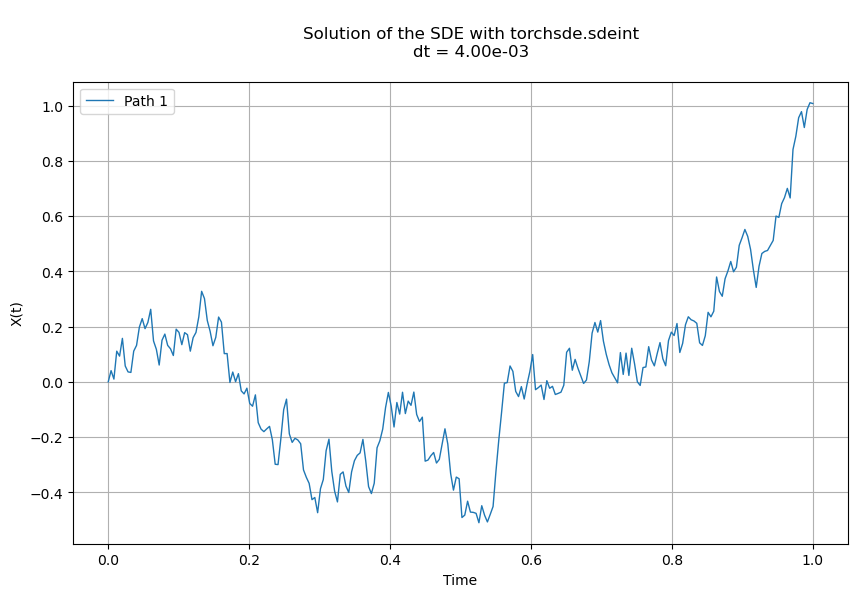

In [41]:
fig, ax = plot_sde_samples(
    ts, ys, 
    title=f"""
    Solution of the SDE with torchsde.sdeint
    dt = {dt:.2e}
    """
)

plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
NumPyro model
</div>

In [ ]:
# MODIFY TO PASS A BROWNIAN MOTION dBt

# def numpyro_BNN_model(t, X=None, dBt=None, n_hidden=16):
# in the transition model :
# if dW is None:
#    x_k_plus_1 = numpyro.sample(...)
# else:
#    x_k_plus_1 = drift(...) : déterministe
# 
def numpyro_BNN_model(t, X=None, n_hidden=16):
    """
    SDE in NumPyro / JAX.
    Inputs:
        t : jnp.array of shape (N,)
        X : jnp.array of shape (N,), optional observations
    """
    N = t.shape[0]
    activation = jnp.tanh
    dt = t[1:] - t[:-1]  # (N-1,)
    eps = 1e-8
    
    # drift prior
    drift_w1 = numpyro.sample("drift_w1", dist.Normal(jnp.zeros((n_hidden)), jnp.ones((n_hidden))))  # N_H
    drift_b1 = numpyro.sample("drift_b1", dist.Normal(jnp.zeros((n_hidden)), jnp.ones((n_hidden)))) # N_H
    drift_w2 = numpyro.sample("drift_w2", dist.Normal(jnp.zeros((1,n_hidden)), jnp.ones((1,n_hidden))))  # 1 x N_H
    drift_b2 = numpyro.sample("drift_b2", dist.Normal(jnp.zeros((1)), jnp.ones((1)))) # 1
    
    # print(f"w1 : {drift_w1.shape}")
    # print(f"b1 : {drift_b1.shape}")
    # print(f"w2 : {drift_w2.shape}")
    # print(f"b2 : {drift_b2.shape}")
    
    def drift(x):
        # X_t () -> F(X_t,t) () # scalar
        x = x.ravel()
        # print(f"x1 : {x.shape}")
        x = activation(drift_w1 * x + drift_b1) # (N_H)
        # print(f"x2 : {x.shape}")
        x = jnp.squeeze(drift_w2 @ x[:,None] + drift_b2) # scalar
        # print(f"x3 : {x.shape}")
        return x
    
    # diffusion prior
    diffusion_w1 = numpyro.sample("diffusion_w1", dist.Normal(jnp.zeros((n_hidden)), jnp.ones((n_hidden))))  # N_H
    diffusion_b1 = numpyro.sample("diffusion_b1", dist.Normal(jnp.zeros((n_hidden)), jnp.ones((n_hidden)))) # N_H
    diffusion_w2 = numpyro.sample("diffusion_w2", dist.Normal(jnp.zeros((1,n_hidden)), jnp.ones((1,n_hidden))))  # 1 x N_H
    diffusion_b2 = numpyro.sample("diffusion_b2", dist.Normal(jnp.zeros((1)), jnp.ones((1)))) # 1
    
    def diffusion(x):
        # X_t () -> L(X_t,t) () # scalar
        x = x.ravel()
        x = activation(diffusion_w1 * x + diffusion_b1) # N_H
        x = jnp.squeeze(diffusion_w2 @ x[:,None] + diffusion_b2) # scalar
        x = jnp.exp(x)  # must be > 0
        return x

    # x0 prior
    x0 = numpyro.sample("x_0", dist.Normal(0., 0.1), obs=None if X is None else X[0])
    
    def transition_model(x_k, inputs):
        #
        # signature is transition(x_k, (obs_{k+1}, dt_k)) -> (x_{k+1}, x_{k+1})
        #
        # do use t_prev in this first version : assume SDE is time-invariant
        obs_k_plus_1, dt_k, k = inputs
        # this is the transition model
        x_k_plus_1 = numpyro.sample(
            f"x_{k}",
            dist.Normal(
                loc=drift(x_k)*dt_k+x_k,
                scale=diffusion(x_k)*jnp.sqrt(dt_k)+eps,
                ),
            # obs = None if jnp.isnan(obs_k_plus_1) else obs_k_plus_1
            obs = obs_k_plus_1
        )
        return x_k_plus_1, x_k_plus_1
        
    # prepare inputs for scan
    obs_vals = None if X is None else X[1:]
    # obs_vals = jnp.full((N-1,), jnp.nan) if X is None else X[1:]
    indices = jnp.arange(N-1)
    inputs = (obs_vals, dt, indices) if X is not None else ([None]*(N-1),dt, indices)
    
    # scan along time
    _, xs = scan(transition_model, x0, inputs)
    
    return xs

In [ ]:
nuts_kernel = NUTS(numpyro_BNN_model)

MCMC_runner = MCMC(
    nuts_kernel,
    num_warmup=20,
    num_samples=10,
    num_chains=1,
    chain_method="vectorized"
)

MCMC_runner.run(
    jax.random.PRNGKey(0),
    t=jnp.array(ts),
    X=jnp.array(ys)
)

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
0 : Create sample path from a Stochastic Differential Equation
</div>

General formulation : 

\begin{align}
dX_t &= F(X_t,t) dt + L(X_t,t) dB_t \\
X_0 &= x_0
\end{align}

Here :

\begin{align}
X_t &\in \mathbb{R} \\
F &: \mathbb{R} \times \mathbb{R}^{+} \longrightarrow \mathbb{R} \\
L &: \mathbb{R} \times \mathbb{R}^{+} \longrightarrow \mathbb{R}^{+} \\
dB_t &\sim \mathcal{N}(0,dt)
\end{align}

### Ground Truth SDE

In [ ]:
# LAMBDA_OU = 1.0
# SIGMA_OU = 1.0

# lambda_gt = LAMBDA_OU
# sigma_gt = SIGMA_OU

In [ ]:
# class SDE():
#     """
#     Generic class of a SDE
#     """
#     def __init__(self, drift=None, diffusion=None, name=None):
#         """
#         drift ; callable (torch.tensor, torch.tensor) -> torch.tensor 
#         diffusion : callable (torch.tensor, torch.tensor) -> torch.tensor (must output positive)
#         """
#         if name is None:
#             self.name = "Default Ornstein Uhlenbeck (lambda -5.0, diffusion 1.0)"
#         else:
#             self.name = name
#         if drift is None:
#             self.drift = lambda t,x : -LAMBDA_OU * x
#         else:
#             self.drift = drift
#         if diffusion is None:
#             self.diffusion = lambda t,x : SIGMA_OU
#         else:
#             self.diffusion = diffusion

#     def drift(self, t, x):
#         return self.drift(t,x)

#     def diffusion(self, t, x):
#         return self.diffusion(t,x)

#     def __repr__(self) -> str:
#         msg = f"""
#         SDE object, name : {self.name}
#         \tdrift function : {self.drift}
#         \tdiffusion function : {self.diffusion}
#         """
#         return msg

#     def step(self,t,x,dt,dBt=None):
#         """
#         One step of the SDE, from (t,x) to (t+dt, x_{t+dt}). 
#         Return dX_t
#         If the Gaussian increment is not given, sample one.
#         """
#         if dBt is None:
#             eps = torch.randn()
#             dBt = torch.sqrt(dt) * eps
#         return self.drift(t,x) * dt + self.diffusion(t,x) * dBt
    
# sde = SDE()
# print(sde)

In [ ]:
# # simulate path
# N_POINTS = 1000 # number of points in each path
# N_PATHS = 1 # number of paths to sample - usually 1, not sure the MCMC is relevant for > 1

# t_start = 0.0
# t_end = 10.0
# ts = torch.linspace(t_start, t_end, N_POINTS).to(device)  # time stamps where we want the solution, between 0 and 1
# # print(f"Time stamps shape : {ts.shape}")  # shape (N_POINTS,)

# # sanity check on the time scale
# dt = (t_end - t_start) / N_POINTS
# print(f'dt = {dt:.2e}')

# # sampling Brownian motions - we will reuse them for the reconstruction
# bm = torch.randn((N_POINTS-1, N_PATHS))

# y_start = 0.0  # initial condition
# ys = torch.full((N_POINTS, N_PATHS), fill_value=y_start)
# ys_2 = torch.full((N_POINTS, N_PATHS), fill_value=y_start)

# # Euler - Maruyama
# for i in range(1,N_POINTS):
#     ys[i,:] = ys[i-1,:] + sde.step(ts[i-1], ys[i-1], dt, dBt=bm[i-1])  # with SDE
#     # ys_2[i,:] = ys[i-1,:] + -LAMBDA_OU * ys[i-1,:] * dt + SIGMA_OU * bm[i-1]  # hand made
    
# ys = ys.unsqueeze(-1)
# # ys_2 = ys_2.unsqueeze(-1)

# # with torchsde
# y0 = torch.full((N_PATHS, 1), y_start).to(device)  # initial condition 0.25, shape (batch_size=N_PATHS, state_size=1)
# print(f"Initial condition shape : {y0.shape}")  # shape (N_PATHS, 1)

# with torch.no_grad():  # we don't need gradients for this demo
#     ys_sde = torchsde.sdeint(model, y0, ts, method="euler", dt=dt)  # shape (N_POINTS, N_PATHS, 1)
# # print(f"Computed solution samples with torchsde : {ys_3.size()}")

# # print(f"Data shape : {ys.size()}")

In [ ]:
# def plot_sde_samples(ts, ys, title=None):
#     """
#     Utility functions to plot the sampled SDE solutions
#     """
#     fig, ax = plt.subplots(figsize=(10,6))
#     n_points = ts.size()[0]
#     n_paths = ys.size()[1]
    
#     for i, y in enumerate(ys.permute(1,0,2)):  # iterate over paths
#         ax.plot(ts.detach().cpu().numpy(), y.detach().cpu().numpy(), lw=1, alpha=1.0, label=f'Path {i+1}' if i<10 else None)  # plot each path
    
#     if title is None:
#         title = f"DATA (SDE): \n{n_paths} Sampled path(s) of the OSDE ({n_points:.0f} points)"
#     ax.set_title(title)
#     ax.set_xlabel("Time")
#     ax.set_ylabel("X(t)")
#     ax.legend()
#     ax.grid()
        
#     return fig, ax

# fig, ax = plot_sde_samples(
#     ts, ys, 
#     title=f"""
#     Euler Maruyama simulation(s) of the SDE
#     {sde}
#     dt = {dt:.2f}
#     """
# )
# plt.show()

In [ ]:
# fig, ax = plot_sde_samples(
#     ts, ys_2, 
#     title=f"""
#     Euler Maruyama simulation(s) of the SDE (2e methode)
#     {sde}
#     dt = {dt:.2f}
#     """
# )
# plt.show()

In [ ]:
# fig, ax = plot_sde_samples(
#     ts, ys_sde, 
#     title=f"""
#     With torchsde
#     """
# )
# plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
Generative model for Pyro
</div>

The key assumption we make is that the drift and diffusion functions are Bayesian neural networks.

\begin{align}
F(X_t,t) &= BNN_{\text{F}}(X_t,t) \\
L(X_t,t) &= BNN_{\text{L}}(X_t,t) \\
x_0 &\sim \mathcal{N}(0.0, 1.0)
\end{align}

We use a Euler-Maruyama discretization of the SDE, which leads to a Gaussian transition :

\begin{align}
X_{t_{k+1}} - X_{t_k} &\approx F(X_{t_{k}}, t_k) dt + L(X_{t_k},t_k) \mathcal{N}(0,dt) \\
X_{t_{k+1}} \vert X_{t_k} &\sim \mathcal{N}\left( X_{t_{k}} + F(X_{t_{k}}, t_k) dt \, ; \, L(X_{t_k},t_k)^2 dt \right) \\
\end{align}

Leading to:
\begin{align}
p(x_{k+1} \vert x_k) &= \frac{1}{\sqrt{2\pi \sigma_k^2}} \exp{\left( -\frac{(x_{k+1} - \mu_k)^2}{2 \sigma_k^2} \right) }
\end{align}

with:
\begin{align}
\mu_k &= X_{t_{k}} + F(X_{t_{k}}, t_k) dt \\
\sigma_k^2 &= L(X_{t_k},t_k)^2 dt \\
\end{align}

We compute the likelihood based on those assumptions:

\begin{align}
\log{p(x_{1:N})} &= -\frac{1}{2} \sum_{k=0}^{N-1} \log{\sigma_k^2} - \frac{1}{2} \sum_{k=0}^{N-1} \frac{(x_{k+1} - \mu_k)^2}{\sigma_k^2} + \log{p(x_0)} + \text{cte}
\end{align}

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Model
</div>

NB : we declare the `model` as a function, not a class, as we aim at doing MCMC sampling with NumPyro in the end.

In [ ]:
# t = ts
# # X = ys.squeeze()
# X = ys_sde.squeeze()

# print(f'Time stamps : {t.size()}')
# print(f'Values : {X.size()}')

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
A first toy O.U. model to check our pipeline
</div>

In [ ]:
# def pyro_model(t, X=None, dt=dt):
#     # Pyro model to learn parameters
#     # inputs:
#     #   t (torch.tensor) : (N_POINTS,) : this is the tensor of time steps
#     #   X (torch.tensor, optional) : (N_POINTS,) : the tensor of values at times t
    
#     # number of points
#     N = len(t)
#     dt_ = torch.tensor(dt)
    
#     # priors --- here, O.U. toy case
#     # NB : we posit log_Normal distributions on the diffusion as usual
#     drift = pyro.sample("drift", dist.Normal(0., 1.))  
#     log_diffusion = pyro.sample("log_diffusion", dist.Normal(-2.,1.))
    
#     def drift_fun(x,t):
#         return -drift * x
#     def diffusion_fun(x,t):
#         return torch.exp(log_diffusion)
    
#     # this is the prior for x_0 and also the first value for the likelihood calculation
#     # x0 = pyro.sample("x0", dist.Normal(0.,1.))
#     x0 = torch.tensor(y_start)
#     x_current = x0
    
#     # place holder for potential samples
#     output = torch.zeros_like(t)
#     output[0] = x0
    
#     # likelihood
#     for k in pyro.markov(range(1,N)):
#         mu_k = x_current + drift_fun(x_current, t[k-1]) * dt_
#         sigma_k = diffusion_fun(x_current, t[k-1]) * torch.sqrt(dt_)
#         x_next = pyro.sample(
#             f"x_{k}", 
#             dist.Normal(mu_k, sigma_k),
#             obs=X[k] if X is not None else None  # condition on data if provided
#             )
#         output[k] = x_next
#         x_current = x_next
        
#     # return either a sample path, or log prob (X)
#     return output

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
A first NumPyro toy O.U. model to check our pipeline
</div>

In [ ]:
# from pyro_models import numpyro_model

# nuts_kernel = NUTS(numpyro_model)

# MCMC_runner = MCMC(
#     nuts_kernel,
#     num_warmup=500,
#     num_samples=100,
#     num_chains=4,
#     chain_method="vectorized"
# )

# MCMC_runner.run(
#     jax.random.PRNGKey(0),
#     t=jnp.array(t),
#     X=jnp.array(X),
# )

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
2 : MCMC Posterior Sampling
</div>

In [ ]:
# # reset the Store parameters
# pyro.clear_param_store()

# # define the NUTS kernel - takes the generative model itself.
# nuts_kernel = NUTS(
#     model=pyro_model,
#     jit_compile=True, # True for speed, False for debugging
# )

# # define a MCMC sampler with the above kernel
# # does NOT use the model. This is merely the executor of the MCMCKernel
# N_MCMC_SAMPLES = 100
# N_BURNIN = 200
# N_CHAINS = 1

# MCMC_runner = MCMC(
#     kernel=nuts_kernel,
#     num_samples=N_MCMC_SAMPLES,
#     warmup_steps=N_BURNIN,
#     num_chains=N_CHAINS,
#     initial_params=None
# )

# # run the sampler
# MCMC_runner.run(t,X)

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
3 : Checking results of the MCMC run
</div>

In [ ]:
# def display_diag_MCMC(diags):

#     # Extract all 'n_eff' tensors for example : number of effective samples from the Markov chains
#     n_eff_list = []
#     for rv_name, rv_diagnostics in diags.items():
        
#         # We only care about n_eff for the parameters we are sampling (weights, biases, sigma)
#         # Exclude auxiliary or internal diagnostics if they exist.
#         if 'n_eff' in rv_diagnostics and rv_name not in  ['_last_state', 'potential_energy']:
#             # n_eff might be a tensor if the site is multidimensional (like a weight matrix)
#             n_eff_tensor = rv_diagnostics['n_eff']
            
#             # Flatten the tensor and add all its elements to our list
#             n_eff_list.append(n_eff_tensor.flatten())

#     # Concatenate all n_eff tensors into a single 1D tensor
#     all_n_eff = torch.cat(n_eff_list)

#     # Compute the average and minimum ESS
#     average_n_eff = all_n_eff.mean().item()
#     min_n_eff = all_n_eff.min().item()

#     print(f"Total number of stochastic parameters analyzed: {len(all_n_eff)}")
#     print(f"Overall Average Effective Sample Size (ESS): {average_n_eff:.2f}")
#     print(f"Minimum Effective Sample Size (ESS): {min_n_eff:.2f}")

In [ ]:
# ------- PYRO ----------------------------------------------------

# check effective sample size, etc. by getting the dictionnary of results
# The structure is: {'<RV_name>': {'n_eff': tensor, 'r_hat': tensor, ...}, ...}
# diags = MCMC_runner.diagnostics()

# print(MCMC_runner.summary())
# display_diag_MCMC(diags)




In [ ]:
# --------- PYRO -------------------------------------------------

# full_posterior_samples = MCMC_runner.get_samples()

# N_SUBSET = N_MCMC_SAMPLES * N_CHAINS
# posterior_samples = {k: v[:N_SUBSET] for k,v in full_posterior_samples.items()}



In [ ]:
# drift_samples = posterior_samples.get('drift')
# diffusion_samples = torch.exp(posterior_samples.get('log_diffusion'))
# # x0_samples = posterior_samples.get('x0')

# fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=2)

# sns.histplot(drift_samples.cpu().numpy(), bins=50, kde=True, label=f'drift', ax=ax[0])
# ymax=ax[0].get_ylim()[1]*1.1
# # ax[0].vlines(lambda_gt, ymin=0, ymax=ymax, color='green', label='ground truth')
# # ax[0].vlines(lambda_ml, ymin=0, ymax=ymax, color='blue', linestyles='--', label='MLE')
# # ax[0].vlines(lambda_map, ymin=0, ymax=ymax, color='black', linestyles='--', label='MAP')
# ax[0].set_title(f'drift')
# ax[0].legend()
# ax[0].grid()

# sns.histplot(diffusion_samples.cpu().numpy(), bins=50, kde=True, label=f'diffusion', ax=ax[1])
# ymax=ax[1].get_ylim()[1]*1.1
# # ax[0].vlines(lambda_gt, ymin=0, ymax=ymax, color='green', label='ground truth')
# # ax[0].vlines(lambda_ml, ymin=0, ymax=ymax, color='blue', linestyles='--', label='MLE')
# # ax[0].vlines(lambda_map, ymin=0, ymax=ymax, color='black', linestyles='--', label='MAP')
# ax[1].set_title(f'diffusion')
# ax[1].legend()
# ax[1].grid()

# # sns.histplot(x0_samples.cpu().numpy(), bins=50, kde=True, label=f'x0', ax=ax[2])
# # ymax=ax[2].get_ylim()[1]*1.1
# # # ax[0].vlines(lambda_gt, ymin=0, ymax=ymax, color='green', label='ground truth')
# # # ax[0].vlines(lambda_ml, ymin=0, ymax=ymax, color='blue', linestyles='--', label='MLE')
# # # ax[0].vlines(lambda_map, ymin=0, ymax=ymax, color='black', linestyles='--', label='MAP')
# # ax[2].set_title(f'x0')
# # ax[2].legend()
# # ax[2].grid()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
4 : Reconstruction - sampling from posterior, but reusing the initial Brownian motion
</div>

In [ ]:
# predictive = pyro.infer.Predictive(
#     model = pyro_model,
#     posterior_samples = posterior_samples
# )

# # dict of x_k with 1 <= k <= N_POINTS-1
# sampled_states = predictive(ts)  

# # assembling sampled paths
# sampled_paths = torch.full((N_MCMC_SAMPLES*N_CHAINS, N_POINTS), fill_value=y_start)

# for k in range(N_MCMC_SAMPLES*N_CHAINS):
#     sampled_paths[k,1:] = torch.tensor( [sampled_states.get(f'x_{i}')[k] for i in range(1,N_POINTS)] )
    
# # sampled_paths.size()

In [ ]:
# fig, ax = plt.subplots(figsize=(12,6))

# ax.plot(ts.cpu().numpy(), ys.squeeze().cpu().numpy(), label='ground truth', color='black')
# for i in range(N_MCMC_SAMPLES*N_CHAINS):
#     ax.plot(ts.cpu().numpy(), sampled_paths[i].squeeze().cpu().numpy(), alpha=0.05, color='blue')

# ax.grid()
# ax.legend()
# plt.show()

In [ ]:
# # get samples and analyse
# posterior_samples = MCMC_runner.get_samples()

# lambda_samples = torch.exp(posterior_samples.get("log_lambda"))
# hist_counts, bin_edges = np.histogram(lambda_samples.cpu().numpy(), bins=100)
# lambda_map = bin_edges[hist_counts.argmax()]  # approximate MAP

# sigma_samples = torch.exp(posterior_samples.get("log_sigma"))
# hist_counts, bin_edges = np.histogram(sigma_samples.cpu().numpy(), bins=100)
# sigma_map = bin_edges[hist_counts.argmax()]  # approximate MAP

# print(f'lambda :')
# print(f'\tground truth : \t{lambda_gt:.3e}')
# print(f'\tMLE : \t\t{lambda_ml:.3e}')
# print(f'\tMAP : \t\t{lambda_map:.3e}')
# print(f'sigma :')
# print(f'\tground truth : \t{sigma_gt:.3e}')
# print(f'\tMLE : \t\t{sigma_ml:.3e}')
# print(f'\tMAP : \t\t{sigma_map:.3e}')

# fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=3)

# sns.histplot(lambda_samples.cpu().numpy(), bins=50, kde=True, label=f'lambda', ax=ax[0])
# ymax=ax[0].get_ylim()[1]*1.1
# ax[0].vlines(lambda_gt, ymin=0, ymax=ymax, color='green', label='ground truth')
# ax[0].vlines(lambda_ml, ymin=0, ymax=ymax, color='blue', linestyles='--', label='MLE')
# ax[0].vlines(lambda_map, ymin=0, ymax=ymax, color='black', linestyles='--', label='MAP')
# ax[0].set_title(f'lambda')
# ax[0].legend()
# ax[0].grid()

# sns.histplot(sigma_samples.cpu().numpy(), bins=50, kde=True, label=f'sigma', ax=ax[1])
# ymax=ax[1].get_ylim()[1]*1.1
# ax[1].vlines(sigma_gt, ymin=0, ymax=ymax, color='green', label='ground truth')
# ax[1].vlines(sigma_ml, ymin=0, ymax=ymax, color='blue', linestyles='--', label='MLE')
# ax[1].vlines(sigma_map, ymin=0, ymax=ymax, color='black', linestyles='--', label='MAP')
# ax[1].set_title(f'sigma')
# ax[1].legend()
# ax[1].grid()

# ax[2].scatter(lambda_samples.cpu().numpy(), sigma_samples.cpu().numpy(), marker='.', alpha=0.5)
# ax[2].scatter(lambda_gt, sigma_gt, marker='x', s=50.0, color='green', label='ground truth')
# ax[2].scatter(lambda_ml, sigma_ml, marker='x', s=50.0, color='blue', label='MLE')
# ax[2].scatter(lambda_map, sigma_map, marker='x', s=50.0, color='black', label='MAP')
# ax[2].set_title(f'lambda v sigma')
# ax[2].set_xlabel('lambda')
# ax[2].set_ylabel('sigma')
# ax[2].legend()
# ax[2].grid()

# fig.suptitle(f"MCMC sampling for O.U. with lambda x delta_t = {ldt:.3f}")

# plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Checking Posterior quality with visual reconstruction
</div>

- We sample parameters from the posterior, 
- and use the Brownian motion that was sampled to draw the data
- to try to reconstruct the data

In [ ]:
# N_SAMPLES = 5  # number of paths we want to reconstruct

# ids = np.random.choice(int(N_MCMC_SAMPLES*N_CHAINS), N_SAMPLES)
# lambdas_for_reco = lambda_samples[ids]
# sigmas_for_reco = sigma_samples[ids]

# print(f'lambdas sampled from posterior : {lambdas_for_reco}')
# print(f'sigmas sampled from posterior : {sigmas_for_reco}')

In [ ]:
# ys_reco = torch.full((N_POINTS, N_SAMPLES), fill_value=y_start)

# for i, (lambda_for_reco, sigma_for_reco) in enumerate(zip(lambdas_for_reco, sigmas_for_reco)):
#     # looping
#     print(f'path {i+1} : using lambda = {lambda_for_reco:.3e}, sigma = {sigma_for_reco:.3e}')
#     # compute parameter for the EM simulation given the sampled lambda and sigma from posterior
#     a = torch.exp(-lambda_for_reco*torch.tensor(dt))
#     sigma_sim = sigma_for_reco * torch.sqrt(1/(2*lambda_for_reco)*(1-a**2))
#     # compute path from posterior samples, with brownian motion from the data
#     for j in range(1,N_POINTS):
#         ys_reco[j,i] = a * ys_reco[j-1,i] + sigma_sim * bm[j-1,:]
        
# ys_reco = ys_reco.unsqueeze(-1)

In [ ]:
# fig, ax = plt.subplots(figsize=(10,6))
# n_points = ts.size()[0]
# n_paths = ys.size()[1]
    
# for i, y in enumerate(ys_reco.permute(1,0,2)):  # iterate over paths
#     l = lambdas_for_reco[i]
#     s = sigmas_for_reco[i]
#     ax.plot(ts.detach().cpu().numpy(), y.detach().cpu().numpy(), color='blue', lw=1, alpha=0.75, label=f'Path {i+1} - lambda = {l:.2e}, sigma = {s:.2e}' if i<10 else None)  # plot each path
       
# ax.plot(ts.cpu().numpy(), ys.squeeze().cpu().numpy(), color='black', alpha=1.0, label='ground truth', marker='x')

# title = f"RECONSTRUCTING DATA with sampled lambdas, sigmas \nsame brownian motion as ground truth data\nground truth : lambda = {lambda_gt:.3f}, sigma = {sigma_gt:.3f}" 
# ax.set_title(title)
# ax.set_xlabel("Time")
# ax.set_ylabel("X(t)")
# ax.legend()
# ax.grid()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Forecasting
</div>

- We draw lambdas, sigmas from the posterior
- We draw random motions from t_end to t_forecast
- We compute paths from t_end to t_end + t_forecast

In [ ]:
# N_SAMPLES = N_MCMC_SAMPLES * N_CHAINS  # number of paths we want to reconstruct

# ids = np.random.choice(int(N_MCMC_SAMPLES*N_CHAINS), N_SAMPLES)
# lambdas_for_reco = lambda_samples[ids]
# sigmas_for_reco = sigma_samples[ids]

# print(f'lambdas sampled from posterior : {lambdas_for_reco.size()}')
# print(f'sigmas sampled from posterior : {sigmas_for_reco.size()}')

In [ ]:
# N_NEW_POINTS = 20
# t_forecast = t_end + N_NEW_POINTS * dt
# ts_forecast = torch.linspace(t_end, t_forecast, N_NEW_POINTS)

# # sampling Brownian motions - we will reuse them for the reconstruction
# y_start_forecast = ys[-1].item()
# ys_forecast = torch.full((N_NEW_POINTS, N_SAMPLES), fill_value=y_start_forecast)

# # sampling Brownian motions
# bm = torch.randn((N_NEW_POINTS-1, N_SAMPLES))

# # computing forecasts
# for i, (lambda_for_reco, sigma_for_reco) in enumerate(zip(lambdas_for_reco, sigmas_for_reco)):
#     # looping
#     # print(f'forecast path {i+1} : using lambda = {lambda_for_reco:.3e}, sigma = {sigma_for_reco:.3e}, and BM = {bm[:5,i]}')
#     # compute parameter for the EM simulation given the sampled lambda and sigma from posterior
#     a = torch.exp(-lambda_for_reco*torch.tensor(dt))
#     sigma_sim = sigma_for_reco * torch.sqrt(1/(2*lambda_for_reco)*(1-a**2))
#     # compute path from posterior samples, with brownian motion from the data
#     for j in range(1,N_NEW_POINTS):
#         ys_forecast[j,i] = a * ys_forecast[j-1,i] + sigma_sim * bm[j-1,i]

# mean_forecast = torch.mean(ys_forecast, dim=1)
# ys_forecast = ys_forecast.unsqueeze(-1)

In [ ]:
# fig, ax = plt.subplots(figsize=(10,6))
# # n_points = ts.size()[0]
# # n_paths = ys.size()[1]
# LAST_POINTS = 20
    
# for i, y in enumerate(ys_forecast.permute(1,0,2)):  # iterate over paths
#     l = lambdas_for_reco[i]
#     s = sigmas_for_reco[i]
#     ax.plot(ts_forecast.detach().cpu().numpy(), y.detach().cpu().numpy(), color='blue', lw=1, alpha=0.2) # label=f'Path {i+1} - lambda = {l:.2e}, sigma = {s:.2e}' if i<5 else None)  # plot each path

# ax.plot(ts[-LAST_POINTS:].cpu().numpy(), ys[-LAST_POINTS:].squeeze().cpu().numpy(), color='black', alpha=1.0, label='ground truth', marker='x')
# ax.plot(ts_forecast.detach().cpu().numpy(), mean_forecast.detach().cpu().numpy(), color='red', lw=2, linestyle='-', label='simulations mean', alpha=1.0)    

# title = f"FORECASTING paths with sampled lambdas, sigmas \nsampled brownian motion in the future" 
# ax.set_title(title)
# ax.set_xlabel("Time")
# ax.set_ylabel("X(t)")
# ax.legend()
# ax.grid()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
A note on whether or not posterior sampling is useful...
</div>

Recall that 

\begin{align}
dX_t &= - \lambda X_t dt + \sigma dB_t \\
X_0 &= x_0
\end{align}

The big take-away is that if
\begin{align}
\lambda \Delta t << 1
\end{align}

Then $(X_t)_{t \geq 0}$ is close to:
\begin{align}
dX_t &\sim \sigma dB_t \\
X_0 &= x_0
\end{align}

That is the observed $X_t$ is close to a **random walk** and it is very difficult to estimate $\lambda$.

The O.U. process becomes indistinguishable from a random walk at that time scale.

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 60px; color: black; font-weight: bold;">
Take-aways
</div>

High-frequency ≠ high information for λ.

If $\lambda \Delta_t << 1$, treat the path as approximately a Wiener process; focus on $\sigma$

To infer $\lambda$ reliably, you need:
- Larger $\Delta t$, or
- Longer total observation window, spanning multiple relaxation times - ie $\lambda \Delta_t \geq 0.1$ for example